In [1]:
import numpy as np
import nengo
from nengo import Lowpass
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io
from model import DotPerception, build_network, detect_extrema_dot_motion
palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='ticks', rc={'font.size':12, 'mathtext.fontset': 'cm'})

In [2]:
def make_hanks_behavior_dataframe():
    # convert original matlab files into a single pandas dataframe
    dfs = []
    columns = ('type', 'id', 'emphasis', 'trial', 'coherence', 'accuracy', 'RT')

    for name in ['E', 'D']:
        if name=='E': emp = scipy.io.loadmat("data/behavData_eli.mat", simplify_cells=True)
        if name=='D': emp = scipy.io.loadmat("data/behavData_dam.mat", simplify_cells=True)
        for e, emphasis in enumerate(['speed', 'accuracy']):
            cond = emp['task'][e]
            coherences = 100*cond['data']['coh']
            accuracies = 100*cond['data']['cor']
            rts = 0.001*cond['data']['rt']
            trials = coherences.shape[0]
            for t in range(trials):
                dfs.append(pd.DataFrame([['monkey', name, emphasis, t, coherences[t], accuracies[t], rts[t]]], columns=columns))

    hanks_behavior = pd.concat(dfs, ignore_index=True)
    hanks_behavior.to_pickle("data/hanks2014_behavior.pkl")

In [ ]:
# make_hanks_behavior_dataframe()

In [2]:
def chi_squared_distance(a,b):
    distance = 0
    for i in range(len(a)):
        if a[i]+b[i]==0:
            continue
        else:
            distance += np.square(a[i] - b[i]) / (a[i]+b[i])
    return distance

def get_error(simulated, empirical, coherences, emphases, bins):
    for emphasis in emphases:
        chis = []
        accs = []
        for coherence in coherences:
            rts_sim = simulated.query("emphasis==@emphasis & coherence==@coherence")['RT'].to_numpy()
            rts_emp = empirical.query("emphasis==@emphasis & coherence==@coherence")['RT'].to_numpy()
            accs_sim = simulated.query("emphasis==@emphasis & coherence==@coherence")['accuracy'].to_numpy()
            accs_emp = empirical.query("emphasis==@emphasis & coherence==@coherence")['accuracy'].to_numpy()
            hist_rts_sim = np.histogram(rts_sim, bins=bins)[0]
            hist_rts_emp = np.histogram(rts_emp, bins=bins)[0]
            normed_hist_rts_sim = hist_rts_sim / len(rts_sim)
            normed_hist_rts_emp = hist_rts_emp / len(rts_emp)
            chi = chi_squared_distance(normed_hist_rts_sim, normed_hist_rts_emp)
            acc = np.abs(np.mean(accs_sim) - np.mean(accs_emp))
            chis.append(chi)
            accs.append(acc)
        print('emphasis', emphasis, f'chi2 {np.sum(chis):.3}', f'accuracy {np.sum(accs):.3}')

# Empirical

In [30]:
def compare_monkeys():
    hanks_behavior = pd.read_pickle("data/hanks2014_behavior.pkl").query("coherence>0")
    cohs = 100*np.array([0.032, 0.064, 0.128, 0.256, 0.512])
    error = ('ci', 95)
    bins = np.arange(0, 1.5, 0.1)
    
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=((7.08, 4)))
    sns.lineplot(data=hanks_behavior, x='coherence', y='RT', hue='emphasis',
                 palette=palette[:2], markers=True, ax=axes[0],
                 style='id', errorbar=error, estimator=np.median)
    sns.lineplot(data=hanks_behavior, x='coherence', y='accuracy', hue='emphasis',
                 palette=palette[:2], markers=True, ax=axes[1],
                 style='id', errorbar=error, estimator=np.mean)
    axes[0].set(ylabel="Response Time (s)")
    axes[0].legend(ncols=2)
    axes[0].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Reaction Time (s)")
    axes[1].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Accuracy (%)")
    axes[1].get_legend().remove()
    plt.tight_layout()
    
    fig = sns.FacetGrid(hanks_behavior, col='emphasis', row="coherence", hue='id', palette=palette[:2],
                        height=1.5, aspect=3, sharex=True, legend_out=True)
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", common_norm=False, bins=bins)
    fig.set_xlabels("Response Time (s)")
    fig.set(xticks=bins[::2])
    fig.set(yticks=[0,25,50,75,100])
    fig.add_legend()

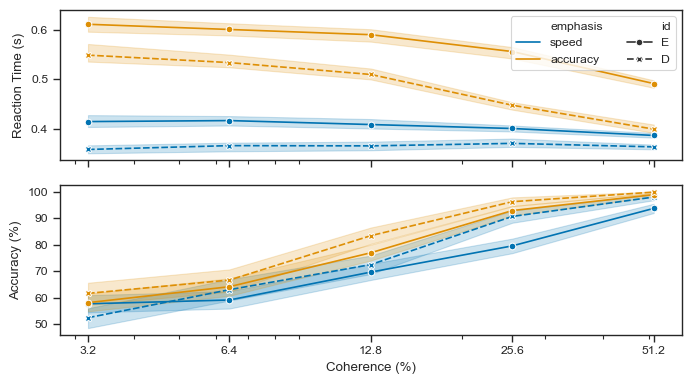

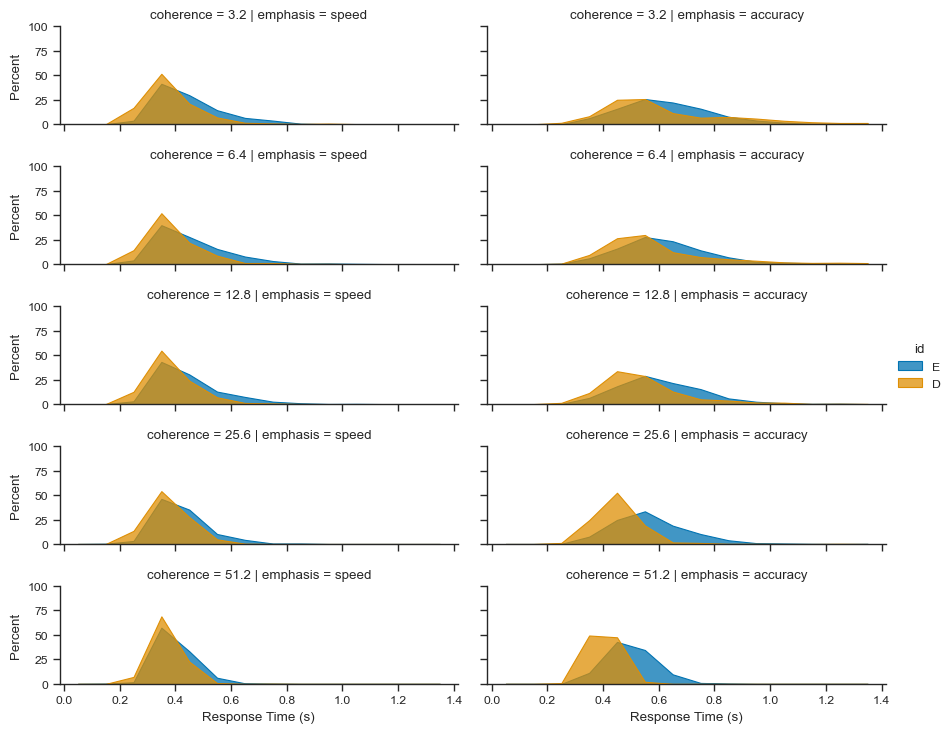

In [31]:
compare_monkeys()

In [34]:
def plot_emp_firing_rates():
    emp = scipy.io.loadmat("data/psthData.mat", simplify_cells=True)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=((7, 3)), sharey=True, sharex=True)
    sns.lineplot(emp['psth_forBo_acc'][0], color=palette[0], ax=axes[0])
    sns.lineplot(emp['psth_forBo_acc'][1], color=palette[1], ax=axes[0])
    sns.lineplot(emp['psth_forBo_acc'][2], color=palette[2], ax=axes[0])
    sns.lineplot(emp['psth_forBo_acc'][3], color=palette[3], ax=axes[0])
    sns.lineplot(emp['psth_forBo_acc'][4], color=palette[4], ax=axes[0])
    sns.lineplot(emp['psth_forBo_sp'][0], color=palette[0], ax=axes[1])
    sns.lineplot(emp['psth_forBo_sp'][1], color=palette[1], ax=axes[1])
    sns.lineplot(emp['psth_forBo_sp'][2], color=palette[2], ax=axes[1])
    sns.lineplot(emp['psth_forBo_sp'][3], color=palette[3], ax=axes[1])
    sns.lineplot(emp['psth_forBo_sp'][4], color=palette[4], ax=axes[1])
    axes[0].set(ylabel='Firing Rate', xlabel='Time (ms)', title='Accuracy Emphasis')
    axes[1].set(xlabel='Time (ms)', title='Speed Emphasis')
    plt.tight_layout()
    fig.savefig(f"plots/hanks_psth.png", dpi=600)

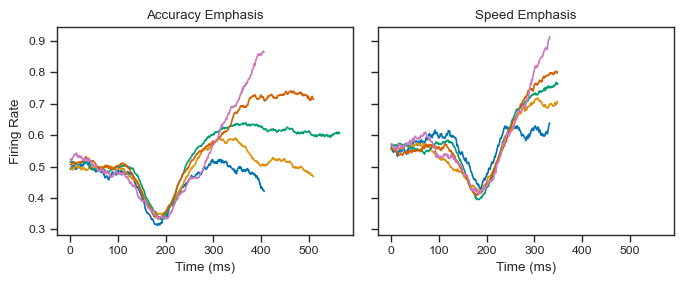

In [35]:
plot_emp_firing_rates()

# Simulate

In [29]:
def simulate(
        coherences=np.array([0.032, 0.064, 0.128, 0.256, 0.512]),
        emphases=['speed', 'accuracy'],
        pid="E",
        ramps=[1.0, 1.0],
        thresholds=[0.3, 0.3],
        relatives=[0.5, 0.5],
        sigmas=[0.5, 0.5],
        dt_samples=[0.03, 0.03],
        nActions=2,
        nNeurons=500,
        max_rates=nengo.dists.Uniform(60, 80),
        rA=1.0,
        trials=10,
        perception_seed=0,
        dt=0.001,
        load=False,
        tmax=2,
        t0=0.1,
        t1=-0.1,
        name="hanks_activity_default"):
    
    columns = ['type', 'id', 'emphasis', 'coherence', 'trial', 'accuracy', "RT", 'mean buildup rate', 'mean final rate']
    dfs = []
    for e, emphasis in enumerate(emphases):
        ramp = ramps[e]
        threshold = thresholds[e]
        relative = relatives[e]
        sigma = sigmas[e]
        dt_sample = dt_samples[e]
        inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
        for coherence in coherences:
            inputs.create(coherence=coherence)
            print(emphasis, coherence)
            for trial in range(trials):
                net = build_network(inputs, nActions=nActions, nNeurons=nNeurons, rA=rA, seed=trial,
                                    max_rates=max_rates, ramp=ramp, threshold=threshold, relative=relative,
                                    probe_spikes=True)
                sim = nengo.Simulator(net, progress_bar=False)
                choice = None
                while choice==None:
                    sim.run(dt)
                    if np.any(sim.data[net.pAction][-1,:] > 0.01):
                        choice = np.argmax(sim.data[net.pAction][-1,:])
                        RT = sim.trange()[-1]
                    if sim.trange()[-1] > tmax:
                        choice = np.argmax(sim.data[net.pValue][-1,:])
                        RT = sim.trange()[-1]
                correct = True if choice==inputs.correct else False
                aligned_neuron_idx = np.argwhere(sim.data[net.value].encoders[:,inputs.correct] > 0.9).ravel()
                # print(f"emphasis {emphasis}, coherence {coherence}, trial {trial}, RT {RT}, aligned neurons {len(aligned_neuron_idx)}")
                DT = RT - t1
                buildup_rates = []
                final_rates = []
                for neuron in aligned_neuron_idx:
                    A0 = sim.data[net.pSpikes][int(t0/dt),neuron]
                    A1 = sim.data[net.pSpikes][int(t1/dt),neuron]
                    DA =  A1 - A0 
                    if A1!=0 and A0!=0:
                        buildup_rate = DA/DT
                        dfs.append(pd.DataFrame([['model', 'S', emphasis, 100*coherence, trial, 100*correct, RT, buildup_rate, A1]], columns=columns))
#                 dfs.append(pd.DataFrame([['model', 'S', emphasis, 100*coherence, trial, 100*correct, RT, np.mean(buildup_rates), np.mean(final_rates)]], columns=columns))
    data = pd.concat(dfs, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")

In [4]:
def simulate_extrema_separate(
        coherences=[0.032, 0.064, 0.128, 0.256, 0.512],
        sigmas=[0.3, 0,3],
        thresholds=[1.0, 1.0],
        tiebreakers=['largest', 'largest'],
        dt_samples=[0.01, 0.01],
        nd_means=[0,0],
        nd_sigmas=[0,0],
        tmax=3,
        trials=400,
        perception_seed=0,
        network_seed=0,
        name='hanks_extrema_separate'):
    
    rng = np.random.RandomState(seed=network_seed)
    columns = ('type', 'trial', 'coherence', 'emphasis', 'RT', 'accuracy')  # same as Churchland dataframe
    dfs = []
    for n, emphasis in enumerate(['speed', 'accuracy']):
        threshold = thresholds[n]
        dt_sample = dt_samples[n]
        tiebreaker = tiebreakers[n]
        sigma = sigmas[n]
        nd_mean = nd_means[n]
        nd_sigma = nd_sigmas[n]
        inputs = DotPerception(nActions=2, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
        for coherence in coherences:
            for trial in range(trials):
                inputs.create(coherence=coherence)
                choice, RT = detect_extrema_dot_motion(inputs, threshold, tiebreaker, tmax=tmax, seed=network_seed)
                correct = True if choice==inputs.correct else False
                ndt = rng.normal(nd_mean, nd_sigma)
                ndt = np.max([0, ndt])
                RT += ndt  # add non-decision time to model's RT
                # print(f"emphasis {emphasis}, coherence {coherence}, trial {trial}, RT {RT}")
                dfs.append(pd.DataFrame([['extrema', trial, 100*coherence, emphasis, RT, 100*correct]], columns=columns))
    data = pd.concat(dfs, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")

# Plot

In [42]:
def plot_correct_incorrect(simfile, extrfile, empfile="hanks2014_behavior", error=('ci', 95), estimator=np.median, bins=np.arange(0.0, 2, 0.2)):
    
    sim = pd.read_pickle(f'data/{simfile}.pkl')
    extr = pd.read_pickle(f'data/{extrfile}.pkl')
    emp = pd.read_pickle(f'data/{empfile}.pkl').query("id=='E' & coherence>0")
    combined = pd.concat([emp, sim, extr])
    cohs = combined['coherence'].unique()
    combined = combined.query("coherence in @cohs")

    fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=False, figsize=((7.08, 6)))
    sns.lineplot(data=combined.query("emphasis=='speed' & type=='monkey'"), x='coherence', y='RT', style='accuracy', color=palette[0], markers=True, ax=axes[0][0],
                 errorbar=error, estimator=estimator)
    sns.lineplot(data=combined.query("emphasis=='accuracy' & type=='monkey'"), x='coherence', y='RT', style='accuracy', color=palette[0], markers=True, ax=axes[0][1],
                 errorbar=error, estimator=estimator)
    sns.lineplot(data=combined.query("emphasis=='speed' & type=='model'"), x='coherence', y='RT', style='accuracy', color=palette[1], markers=True, ax=axes[1][0],
                 errorbar=error, estimator=estimator)
    sns.lineplot(data=combined.query("emphasis=='accuracy' & type=='model'"), x='coherence', y='RT', style='accuracy', color=palette[1], markers=True, ax=axes[1][1],
                 errorbar=error, estimator=estimator)
    sns.lineplot(data=combined.query("emphasis=='speed' & type=='extrema'"), x='coherence', y='RT', style='accuracy', color=palette[2], markers=True, ax=axes[2][0],
                 errorbar=error, estimator=estimator)
    sns.lineplot(data=combined.query("emphasis=='accuracy' & type=='extrema'"), x='coherence', y='RT',style='accuracy', color=palette[2], markers=True, ax=axes[2][1],
                 errorbar=error, estimator=estimator)
    axes[0][0].set(ylabel="Response Time (s)", title="Speed Emphasis, Human")
    axes[0][1].set(ylabel=None, title="Accuracy Emphasis, Human")
    axes[1][0].set(ylabel="Response Time (s)", title="Speed Emphasis, Model")
    axes[1][1].set(ylabel=None, title="Accuracy Emphasis, Model")
    axes[2][0].set(title="Speed Emphasis, Extrema")
    axes[2][1].set(ylabel=None, title="Accuracy Emphasis, Extrema")
    axes[2][0].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Response Time (s)")
    axes[2][1].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)")
    axes[0][1].get_legend().remove()
    axes[1][0].get_legend().remove()
    axes[1][1].get_legend().remove()
    axes[2][0].get_legend().remove()
    axes[2][1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/hanks_correct_incorrect.svg")
    fig.savefig(f"plots/hanks_correct_incorrect.png", dpi=600)

In [21]:
def plot_RTs(simfile, extrfile, empfile="hanks2014_behavior", bins=np.arange(0.0, 2, 0.2)):

    sim = pd.read_pickle(f'data/{simfile}.pkl')
    extr = pd.read_pickle(f'data/{extrfile}.pkl')
    emp = pd.read_pickle(f'data/{empfile}.pkl').query("id=='E' & coherence>0")
    combined = pd.concat([emp, sim, extr])
    cohs = combined['coherence'].unique()
    combined = combined.query("coherence in @cohs")

    fig = sns.FacetGrid(combined, row='coherence', hue='type', col="emphasis", col_order=["speed", "accuracy"], palette=palette, height=2, aspect=1.5)
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", bins=bins, common_norm=False)
    fig.set_xlabels("Response Time (s)")
    fig.add_legend()
    fig.savefig(f"plots/hanks_RT.svg")
    fig.savefig(f"plots/hanks_RT.png", dpi=600)

In [11]:
def plot_sat(simfile, extrfile, empfile="hanks2014_behavior", error=('ci', 95), estimator=np.median, bins=np.arange(0.0, 1.5, 0.1)):
    sim = pd.read_pickle(f'data/{simfile}.pkl')
    extr = pd.read_pickle(f'data/{extrfile}.pkl')
    emp = pd.read_pickle(f'data/{empfile}.pkl').query("id=='E'")
    combined = pd.concat([emp, sim, extr])
    cohs = combined['coherence'].unique()[1:]
    combined = combined.query("coherence in @cohs")

    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=((7, 5)))
    sns.lineplot(data=combined, x='coherence', y='RT', hue='type', style='emphasis',
                 palette=palette[:3], markers=True, ax=axes[0], estimator=estimator)
    sns.lineplot(data=combined, x='coherence', y='accuracy', hue='type', style='emphasis',
                 palette=palette[:3], markers=True, ax=axes[1])
    axes[0].set(xscale='log', xlabel="Coherence (%)", ylabel="Response Time (s)")
    axes[0].legend(ncols=2, loc='upper right')
    axes[1].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Accuracy (%)", yticks=[50,60,70,80,90,100])
    axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/hanks_sat.svg")
    fig.savefig(f"plots/hanks_sat.png", dpi=600)

In [12]:
def plot_activity(simfile, empfile="hanks2014_behavior", estimator=np.mean, errorbar=('pi', 20)):
    sim = pd.read_pickle(f'data/{simfile}.pkl')
    cohs = sim['coherence'].unique()[1:]
    # emp = pd.read_pickle(f'data/{empfile}.pkl').query("id=='E'")
    # combined = pd.concat([emp, sim])
    # cohs = combined['coherence'].unique()[1:]
    # combined = combined.query("coherence in @cohs")
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=((7, 3)))
    sns.lineplot(data=sim, x='coherence', y='mean buildup rate', hue='emphasis',
                 palette=palette[:2], markers=True, ax=axes[0], errorbar=errorbar, estimator=estimator)
    sns.lineplot(data=sim, x='coherence', y='mean final rate', hue='emphasis',
                 palette=palette[:2], markers=True, ax=axes[1], errorbar=errorbar, estimator=estimator)
    axes[0].set(xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Mean Buildup Rate (Hz/s)")
    axes[1].set(xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Mean Final Rate (Hz/s)")
    # axes[0].legend(ncols=2, loc='upper right')
    axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/hanks_firing_rates.svg")
    fig.savefig(f"plots/hanks_firing_rates.png", dpi=600)

# Results

In [30]:
simulate(
    trials=100,
    ramps=[1.0, 1.24],
    thresholds=[0.3, 0.27],
    relatives=[0.5, 0.41],
    sigmas=[0.5, 0.53],
    dt_samples=[0.03, 0.056],
)

speed 0.032


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:624: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


speed 0.064
speed 0.128
speed 0.256
speed 0.512
accuracy 0.032
accuracy 0.064
accuracy 0.128
accuracy 0.256
accuracy 0.512


In [ ]:
simulate_extrema_separate(
    trials=1000,
    thresholds=[1.01, 0.67],
    dt_samples=[0.016, 0.069],
    sigmas=[0.35, 0.16],
    nd_means=[0.34, 0.48],
    nd_sigmas=[0.04, 0.08],
    tiebreakers=['largest', 'largest'])

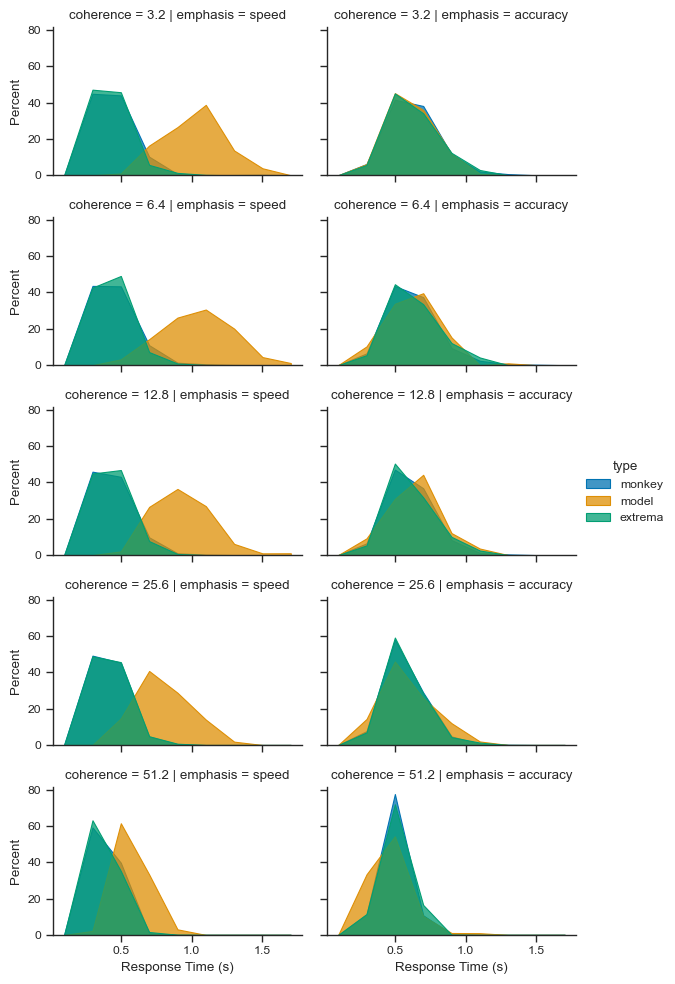

In [31]:
plot_RTs("hanks_activity_default", "hanks_extrema_separate", "hanks2014_behavior")  # "dec27sigma06"

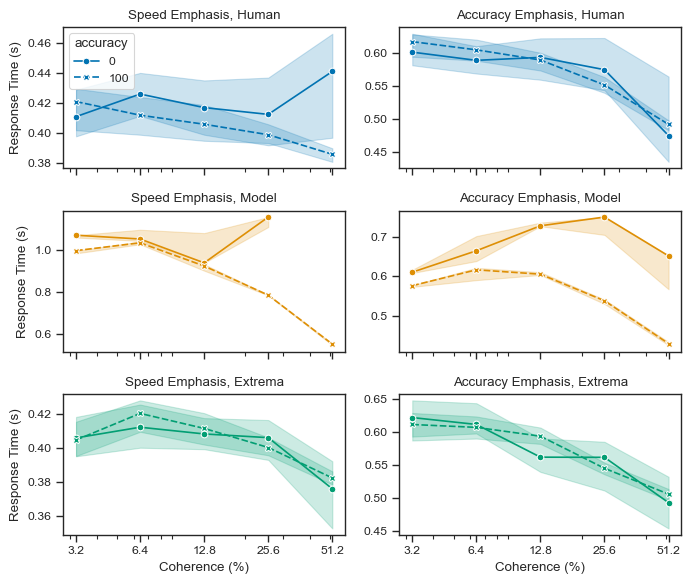

In [43]:
plot_correct_incorrect("hanks_activity_default", "hanks_extrema_separate", "hanks2014_behavior")  # "dec27sigma06"

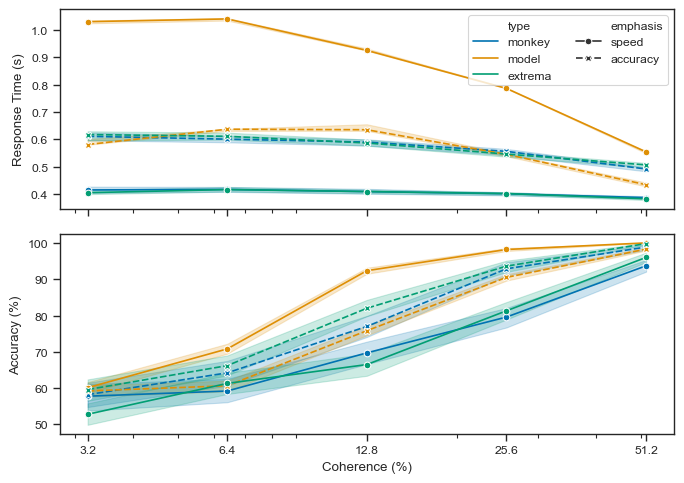

In [33]:
plot_sat("hanks_activity_default", "hanks_extrema_separate", "hanks2014_behavior")  # "dec27sigma06"

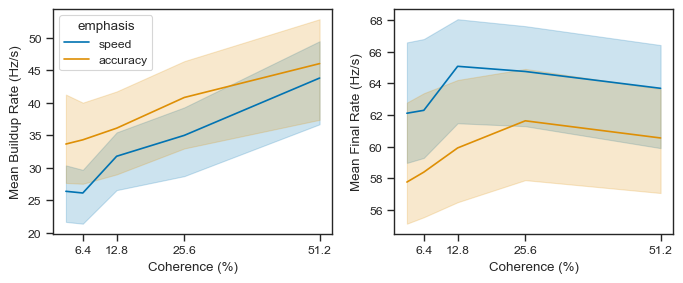

In [34]:
plot_activity("hanks_activity_default", "hanks2014_behavior")  # "dec27sigma06"

## Etc

In [37]:
emp = pd.read_pickle(f'data/hanks2014_behavior.pkl').query("id=='E' & coherence>0")
cohs = emp['coherence'].unique()
for coh in cohs:
    print(coh, len(emp.query("coherence==@coh")['trial'].unique()))

25.6 1488
51.2 1460
6.4 1475
3.2 1459
12.8 1486
